<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #11: Análisis de sentimiento

### Jairo Iván Ordóñez
### Grupo 51
`Fecha de entrega: Noviembre 21, 2020 (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [1]:
import pandas as pd
import numpy as np
import tweepy
import re
import regex
import emoji

import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)
import seaborn as sns

from collections import Counter

from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from flair.models import TextClassifier
from flair.data import Sentence

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

from nltk.corpus import stopwords
stopwords = stopwords.words('spanish')
import PIL.Image
from IPython.display import display

In C:\Jairo.Ordonez\2. Personal\Data Science Program\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Jairo.Ordonez\2. Personal\Data Science Program\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Jairo.Ordonez\2. Personal\Data Science Program\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Jairo.Ordonez\2. Personal\Data Science Program\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.

In [2]:
# Leer llaves
keys = pd.read_csv("../../Clase_12/Keys_Tw.txt", header=None)
keys = dict(zip(keys[0], keys[1]))

# Autenticar a través de la API
auth = tweepy.OAuthHandler(keys['api_key'],keys['api_secret_key'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)


tweets = tweepy.Cursor(api.search,
                       q=['#BuenaPapa -RT'],
                       lang='es',
                       geocode = f'4.60971,-74.08175,80km',
                       tweet_mode='extended',
                       include_rts=False).items(1000)

t = []
for tweet in tweets:
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
        
    t.append(temp)

data = pd.DataFrame(t)
data.columns = ['tweet', 'date']
data.head()

,tweet,date
0,¡Qué #BuenaPapa! Gran trabajo el que estamos ...,2020-11-14 16:31:57
1,"El campo nos necesita, seamos #BuenaPapa https...",2020-11-14 16:21:41
2,Apoyando a los campesinos. #CundinamarcaEsBuen...,2020-11-14 16:11:16
3,"Únete a la #Papatón, este 14 de noviembre de 7...",2020-11-14 16:00:01
4,Apoya el campo colombiano sin intermediarios.\...,2020-11-14 15:59:04


In [3]:
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweet']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
             
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")
        
    return text, links, hashtags, mentions

data[['clean', 'links', 'hashtags','mentions']] = data.apply(text_clean, axis=1, result_type='expand')

In [4]:
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
        
    return emoji_list

data['emojis'] = data['clean'].apply(lambda text: get_emojis(text))

In [5]:
data.head()

,tweet,date,clean,links,hashtags,mentions,emojis
0,¡Qué #BuenaPapa! Gran trabajo el que estamos ...,2020-11-14 16:31:57,¡Qué Gran trabajo el que estamos realizando ...,[https://t.co/uQx5Zi6GwM],"[#BuenaPapa!, #CundinamarcaEsBuenaPapa, #Regió...","[@CundinamarcaGob,]",[]
1,"El campo nos necesita, seamos #BuenaPapa https...",2020-11-14 16:21:41,"El campo nos necesita, seamos",[https://t.co/92oi4QeuWD],[#BuenaPapa],[],[]
2,Apoyando a los campesinos. #CundinamarcaEsBuen...,2020-11-14 16:11:16,Apoyando a los campesinos.,[https://t.co/RcxZNbDesm],"[#CundinamarcaEsBuenaPapa, #BuenaPapa]",[],[]
3,"Únete a la #Papatón, este 14 de noviembre de 7...",2020-11-14 16:00:01,Únete a la este 14 de noviembre de 7am a 4pm ...,"[https://t.co/zBHeh9OQPV, https://t.co/KWch4S9...","[#Papatón,, #BuenaPapa,]",[@IPESBogota],"[💻, ☎️]"
4,Apoya el campo colombiano sin intermediarios.\...,2020-11-14 15:59:04,Apoya el campo colombiano sin intermediarios.\...,[https://t.co/Lo1lhDkUoX],"[#BuenaPapa, #LaFuerzaQueNosRepresenta]",[],[]


In [6]:
traductor = Translator()
data['ing'] = data['clean'].apply(lambda valor: traductor.translate(valor, src='es', dest='en'))
data['ingles'] = data['ing'].apply(lambda valor: valor.text)

###  `[25 pts]` Punto 1: Hacer análisis de sentimiento de los datos del anterior taller
- Columna con el puntaje numérico del sentimiento
- Pueden usar cualquiera de las librerias vistas en clase

In [7]:
vader = SentimentIntensityAnalyzer()
classifier = TextClassifier.load('en-sentiment')

def sent_flair(texto):
    sentence = Sentence(texto)
    classifier.predict(sentence)
    result = sentence.labels[0]
    label = result.value
    score = result.score
    if label == 'POSITIVE':
        return score
    if label == 'NEGATIVE':
        return -1 * score
    return score

2020-11-14 11:50:00,979 loading file C:\Users\eordjai\.flair\models\sentiment-en-mix-distillbert_3.1.pt


In [8]:
data['sent_TextBlob'] = data['ingles'].apply(lambda valor: TextBlob(valor).sentiment.polarity)
data['sent_Vader'] = data['ingles'].apply(lambda valor: vader.polarity_scores(valor)['compound'])
data['sent_flair'] = data['ingles'].apply(lambda valor: sent_flair(valor))

In [9]:
data=data[['tweet','clean','ingles','sent_TextBlob','sent_Vader','sent_flair']]
data.head()

,tweet,clean,ingles,sent_TextBlob,sent_Vader,sent_flair
0,¡Qué #BuenaPapa! Gran trabajo el que estamos ...,¡Qué Gran trabajo el que estamos realizando ...,What a great job that all the secretariats of ...,0.40,0.7783,0.989757
1,"El campo nos necesita, seamos #BuenaPapa https...","El campo nos necesita, seamos","The field needs us, let's be",0.00,0.0000,0.998892
2,Apoyando a los campesinos. #CundinamarcaEsBuen...,Apoyando a los campesinos.,Supporting the peasants.,0.25,0.4404,0.687403
3,"Únete a la #Papatón, este 14 de noviembre de 7...",Únete a la este 14 de noviembre de 7am a 4pm ...,Join this November 14 from 7am to 4pm shopping...,0.00,0.5994,-0.913780
4,Apoya el campo colombiano sin intermediarios.\...,Apoya el campo colombiano sin intermediarios.\...,Support the Colombian countryside without inte...,0.00,0.4019,-0.563187


In [10]:
datosSent = pd.melt(data
        , value_vars=['sent_TextBlob','sent_Vader','sent_flair'] )
datosSent.rename(columns={"variable": "Metodo", "value":"Polaridad"}, inplace=True)
datosSent.head()

,Metodo,Polaridad
0,sent_TextBlob,0.40
1,sent_TextBlob,0.00
2,sent_TextBlob,0.25
3,sent_TextBlob,0.00
4,sent_TextBlob,0.00


<AxesSubplot:xlabel='Metodo', ylabel='Polaridad'>

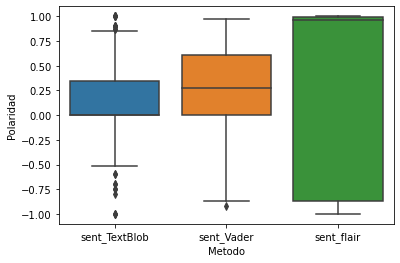

In [11]:
sns.boxplot(data=datosSent, x='Metodo', y='Polaridad')

Vemos que con el método de __TextBlob__ la mediana de la polaridad está más hacia la neutralidad, mientras que el método __Vader__ tiene mayor distribución de las polaridades. El método __Flair__, tiende a ser muy distribuido aunque la mediana está más sesgada hacia lo positivo

###  `[10 pts]` Punto 2: ¿Cuál es el tuit más positivo y más negativo?

* Tweet Más Negativo según TextBlob

In [12]:
data[['tweet','sent_TextBlob']].sort_values('sent_TextBlob').head(1).values

array([['No tengo dudas: si me ponen a escoger entre una fuente de caviar y un plato de papa salada con ají, le hecho ají al caviar a ver si esa vaina asquerosa mejora pero me pongo morado de comer papita salada. #BuenaPapa',
        -1.0]], dtype=object)

* Tweet Más Positivo según TextBlob

In [13]:
data[['tweet','sent_TextBlob']].sort_values('sent_TextBlob').tail(1).values

array([['@JuanFEspinosaP @nicolasgarciab @CundinamarcaGob @AngelaMaria29 Excelente iniciativa! #BuenaPapa',
        1.0]], dtype=object)

* Tweet Más Negativo según Vader

In [14]:
data[['tweet','sent_Vader']].sort_values('sent_Vader').head(1).values

array([['Decepcionante @MabelLaraNews camaleónica, hoy es #BuenaPapa, ayer conmovida con la altanería, soberbia, petulancia de #luiscarlosvelez 😢😳\n. https://t.co/nSKfjhETYU https://t.co/TTSZrmytST',
        -0.9201]], dtype=object)

* Tweet Más Positivo según Vader

In [15]:
data[['tweet','sent_Vader']].sort_values('sent_Vader').tail(1).values

array([['Apreciado @JuanFEspinosaP, muchas gracias por el apoyo. Hoy nuestros campesinos se sienten respetados, admirados, apreciados; reciben el cariño de los colombianos y la ayuda que necesitan. #BuenaPapa #CundinamarcaEsBuenaPapa https://t.co/VVyWpcZLxc',
        0.9729]], dtype=object)

* Tweet Más Negativo según Flair

In [16]:
data[['tweet','sent_flair']].sort_values('sent_flair').head(1).values

array([['Miserable asesino .\n#DeLaVacunaPienso \n#NiunliderMas \n#FelizMartes\n#BuenaPapa \n#DiaSinCarne',
        -0.9999775886535645]], dtype=object)

* Tweet Más Positivo según Flair

In [17]:
data[['tweet','sent_flair']].sort_values('sent_flair').tail(1).values

array([['A comprar todos papa este fin de semana! #BuenaPapa https://t.co/RN7Rz02lIA',
        0.9999233484268188]], dtype=object)

###  `[15 pts]` Punto 3: ¿Cuántos tuits positivos/negativos hay en sus datos?

In [18]:
columnas = ['sent_TextBlob','sent_Vader','sent_flair']

tweetsByMethod = []

for columna in columnas:
    lista = []
    print(f"Método: {columna}")
    print(f"* Cantidad de Tuits Negativos: {len(data[data[columna]<0])}")
    print(f"* Cantidad de Tuits Positivos: {len(data[data[columna]>0])}")
    print(f"* Cantidad de Tuits Neutros: {len(data[data[columna]==0])}")
    lista.append(columna)
    lista.append(len(data[data[columna]<0]))
    lista.append(len(data[data[columna]>0]))
    lista.append(len(data[data[columna]==0]))
    print("##############")
    tweetsByMethod.append(lista)
dfTbM = pd.DataFrame(tweetsByMethod)
dfTbM.columns = ['Método', 'numNegativos', 'numPositivos', 'numNeutros']

Método: sent_TextBlob
* Cantidad de Tuits Negativos: 51
* Cantidad de Tuits Positivos: 186
* Cantidad de Tuits Neutros: 165
##############
Método: sent_Vader
* Cantidad de Tuits Negativos: 84
* Cantidad de Tuits Positivos: 224
* Cantidad de Tuits Neutros: 94
##############
Método: sent_flair
* Cantidad de Tuits Negativos: 130
* Cantidad de Tuits Positivos: 272
* Cantidad de Tuits Neutros: 0
##############


###  `[BONUS 5pts]` : Diagrama de barras de la pregunta 3

<AxesSubplot:xlabel='Método', ylabel='numNegativos'>

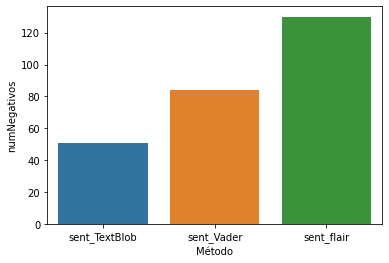

In [19]:
sns.barplot(x="Método", y ="numNegativos", data= dfTbM)

<AxesSubplot:xlabel='Método', ylabel='numPositivos'>

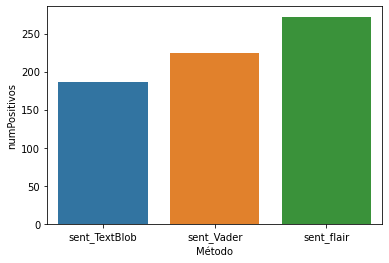

In [20]:
sns.barplot(x="Método", y ="numPositivos", data= dfTbM)

<AxesSubplot:xlabel='Método', ylabel='numNeutros'>

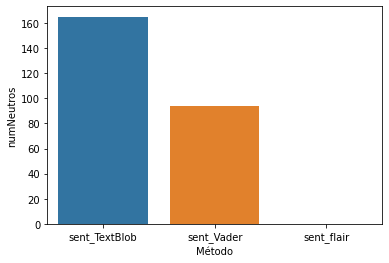

In [21]:
sns.barplot(x="Método", y ="numNeutros", data= dfTbM)

###  `[BONUS 7pts]` : Nubes de palabras por sentimiento

In [22]:
dataPositiva = data[data['sent_Vader']>0]
dataNegativa = data[data['sent_Vader']>0]
textoPositivo = dataPositiva.clean.str.cat(sep=" ")
textoNegativo = dataNegativa.clean.str.cat(sep=" ")

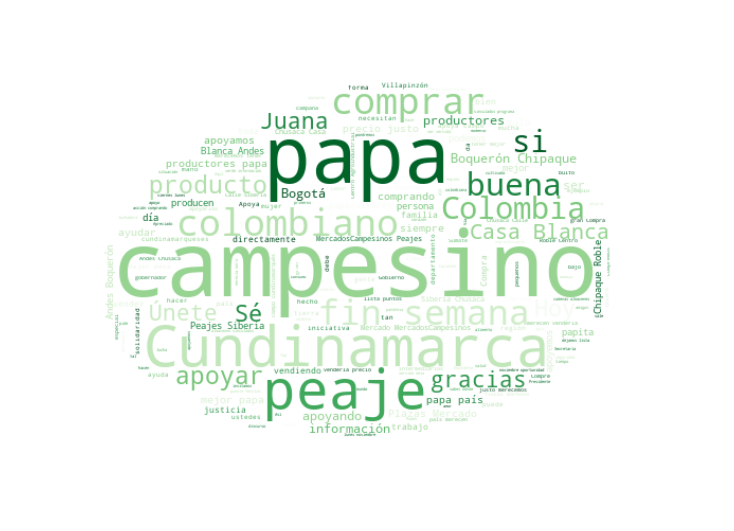

In [23]:
potato = PIL.Image.open("./potato.jpg")
potatoMask = np.array(potato)
wordcloud = WordCloud(width=800, height=400,
                     max_font_size= 150, max_words=250,
                     background_color='white',
                      mask=potatoMask,
                     colormap='Greens',
                     stopwords=stopwords).generate(textoPositivo)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

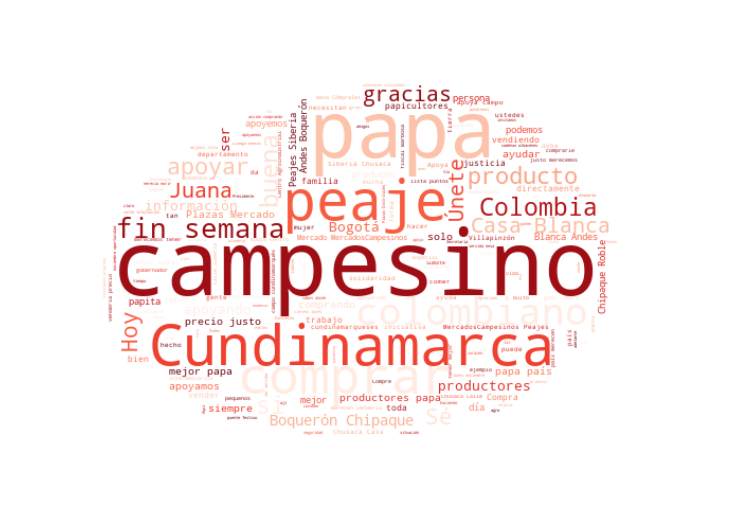

In [24]:
wordcloud = WordCloud(width=800, height=400,
                     max_font_size= 150, max_words=250,
                     background_color='white',
                      mask=potatoMask,
                     colormap='Reds',
                     stopwords=stopwords).generate(textoNegativo)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()